In [4]:
import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

import h5py
import pickle


import fastjet as fj
import Nsubjettiness as Nsub
import numpy as np
import pandas as pd

import glob as glob
import time

In [12]:
fnames = ['/home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1.cmnd_' + str(i) + '.dat' for i in range(1,21)]
#fn = '/home/jack/projects/EMD_VAE/compression_project/data/new_bigger/hv_signal/hv_signal_1_1_1.dat'
# data = np.loadtxt(fnames[2])

In [13]:
columns = []
for i in range(50):
    columns += ['pT' + str(i), 'eta' + str(i), 'phi' + str(i), 'E' + str(i)]

In [14]:
# event_ids = np.unique(data[:,0])
# numevents = len(event_ids)
# events = [data[data[:,0] == i] for i in event_ids]

In [15]:
for fn in fnames:
    
    print("Now processing file", fn)
    data = np.loadtxt(fn)
    event_ids = np.unique(data[:,0])
    numevents = len(event_ids)
    events = [data[data[:,0] == i] for i in event_ids]

    numpass=0
    maxminpT = []

    pass_indices = []

    jet_def = fj.JetDefinition(fj.kt_algorithm, 1.0)


    for n, event in enumerate(events):
#         if n % 1000 == 0:
#             print("Now processing event", n, "of", numevents)
        PIDs = event[:,1]
        pTs = event[:,2]
        eta = event[:,3]
        ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
        isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)
        if np.sum(ismuon) < 1 or np.sum(isantimuon) < 1:
            continue
        pTmu = np.max(pTs[ismuon])
        pTantimu = np.max(pTs[isantimuon])
        maxminpT += [np.min([pTmu,pTantimu])]
        if pTmu < 4.5 or pTantimu < 4.5:
            continue
        numpass += 1
        pass_indices += [n]

    print("Numpass =",numpass,". Fraction =",1.*numpass/len(events))
    
    
    out_data = np.zeros((numpass,50,4))

    HT_muon = []
    HT_tot = []

    for n, index in enumerate(pass_indices):
        if n % 1000 == 0:
            print("Now processing event", n, "of", numpass)

        event = np.array(events[index])
        pTs = event[:,2]
        eta = event[:,3]

        PIDs = event[:,1]
        neutrinos = [12,14,16,4900111]

        ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
        isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)

        mu = np.argmax(pTs*ismuon)
        antimu = np.argmax(pTs*isantimuon)

        rejected = np.zeros(len(event), dtype=bool)
        rejected[mu] = True
        rejected[antimu] = True

        HT_tot += [np.sum(event[:,2])]

        pTs_muon = event[rejected,2]
        HT_muon += [np.sum(pTs_muon)]

        for neutPID in neutrinos:
            rejected += (np.abs(PIDs) == neutPID)

        event = event[np.logical_not(rejected)]


        pTs = event[:,2]
        etas = event[:,3]
        phis = event[:,4]
        Es = event[:,5]

        pxs = pTs*np.cos(phis)
        pys = pTs*np.sin(phis)
        pzs = pTs*np.sinh(etas)

        numparts = len(pTs)

        particles = []
        for i in range(numparts):
            particles += [fj.PseudoJet(pxs[i],pys[i],pzs[i],Es[i])]
        sequence = fj.ClusterSequence(particles,jet_def)
        reclustered = fj.sorted_by_pt(sequence.exclusive_jets(min(50,numparts)))


        numparts = min(50,len(reclustered))
        for j in range(numparts):
            particle = reclustered[j]
            out_data[n,j,0] = particle.pt()
            out_data[n,j,1] = particle.eta()
            out_data[n,j,2] = particle.phi() - np.pi
            out_data[n,j,3] = particle.E()
            
    out_data = out_data.reshape((-1,50*4))
    
    outstore = pd.HDFStore("/home/jack/projects/EMD_VAE/compression_project/data/hv_vector.h5")
    dictionary = dict(zip(columns, out_data.T))
    out_df = pd.DataFrame(dictionary,columns=columns)
    outstore.append('particles',out_df)
    outstore.close()

Now processing file /home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1.cmnd_1.dat
Numpass = 1614 . Fraction = 0.7748439750360058
Now processing event 0 of 1614
Now processing event 1000 of 1614
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1.cmnd_2.dat
Numpass = 1720 . Fraction = 0.7835990888382688
Now processing event 0 of 1720
Now processing event 1000 of 1720
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1.cmnd_3.dat
Numpass = 1651 . Fraction = 0.7552607502287283
Now processing event 0 of 1651
Now processing event 1000 of 1651
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1.cmnd_4.dat
Numpass = 1656 . Fraction = 0.7796610169491526
Now processing event 0 of 1656
Now processing event 1000 of 1656
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_v

In [8]:
fnames = ['/home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1_etadecay.cmnd_' + str(i) + '.dat' for i in range(1,21)]
#fn = '/home/jack/projects/EMD_VAE/compression_project/data/new_bigger/hv_signal/hv_signal_1_1_1.dat'
# data = np.loadtxt(fnames[2])

In [9]:
for fn in fnames:
    
    print("Now processing file", fn)
    data = np.loadtxt(fn)
    event_ids = np.unique(data[:,0])
    numevents = len(event_ids)
    events = [data[data[:,0] == i] for i in event_ids]

    numpass=0
    maxminpT = []

    pass_indices = []

    jet_def = fj.JetDefinition(fj.kt_algorithm, 1.0)


    for n, event in enumerate(events):
#         if n % 1000 == 0:
#             print("Now processing event", n, "of", numevents)
        PIDs = event[:,1]
        pTs = event[:,2]
        eta = event[:,3]
        ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
        isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)
        if np.sum(ismuon) < 1 or np.sum(isantimuon) < 1:
            continue
        pTmu = np.max(pTs[ismuon])
        pTantimu = np.max(pTs[isantimuon])
        maxminpT += [np.min([pTmu,pTantimu])]
        if pTmu < 4.5 or pTantimu < 4.5:
            continue
        numpass += 1
        pass_indices += [n]

    print("Numpass =",numpass,". Fraction =",1.*numpass/len(events))
    
    
    out_data = np.zeros((numpass,50,4))

    HT_muon = []
    HT_tot = []

    for n, index in enumerate(pass_indices):
        if n % 1000 == 0:
            print("Now processing event", n, "of", numpass)

        event = np.array(events[index])
        pTs = event[:,2]
        eta = event[:,3]

        PIDs = event[:,1]
        neutrinos = [12,14,16]

        ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
        isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)

        mu = np.argmax(pTs*ismuon)
        antimu = np.argmax(pTs*isantimuon)

        rejected = np.zeros(len(event), dtype=bool)
        rejected[mu] = True
        rejected[antimu] = True

        HT_tot += [np.sum(event[:,2])]

        pTs_muon = event[rejected,2]
        HT_muon += [np.sum(pTs_muon)]

        for neutPID in neutrinos:
            rejected += (np.abs(PIDs) == neutPID)

        event = event[np.logical_not(rejected)]


        pTs = event[:,2]
        etas = event[:,3]
        phis = event[:,4]
        Es = event[:,5]

        pxs = pTs*np.cos(phis)
        pys = pTs*np.sin(phis)
        pzs = pTs*np.sinh(etas)

        numparts = len(pTs)

        particles = []
        for i in range(numparts):
            particles += [fj.PseudoJet(pxs[i],pys[i],pzs[i],Es[i])]
        sequence = fj.ClusterSequence(particles,jet_def)
        reclustered = fj.sorted_by_pt(sequence.exclusive_jets(min(50,numparts)))


        numparts = min(50,len(reclustered))
        for j in range(numparts):
            particle = reclustered[j]
            out_data[n,j,0] = particle.pt()
            out_data[n,j,1] = particle.eta()
            out_data[n,j,2] = particle.phi() - np.pi
            out_data[n,j,3] = particle.E()
            
    out_data = out_data.reshape((-1,50*4))
    
    outstore = pd.HDFStore("/home/jack/projects/EMD_VAE/compression_project/data/hv_vector_etadecay.h5")
    dictionary = dict(zip(columns, out_data.T))
    out_df = pd.DataFrame(dictionary,columns=columns)
    outstore.append('particles',out_df)
    outstore.close()

Now processing file /home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1_etadecay.cmnd_1.dat
Numpass = 1618 . Fraction = 0.7786333012512031
Now processing event 0 of 1618
Now processing event 1000 of 1618
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1_etadecay.cmnd_2.dat
Numpass = 1705 . Fraction = 0.7824690224873795
Now processing event 0 of 1705
Now processing event 1000 of 1705
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1_etadecay.cmnd_3.dat
Numpass = 1677 . Fraction = 0.7858481724461106
Now processing event 0 of 1677
Now processing event 1000 of 1677
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/newsigs/hv_signal_vector_1_1_1_etadecay.cmnd_4.dat
Numpass = 1693 . Fraction = 0.780184331797235
Now processing event 0 of 1693
Now processing event 1000 of 1693
Now processing file /home/jack/projects/EMD_VAE/compressi

In [25]:
fnames = ['/home/jack/projects/EMD_VAE/compression_project/data/new_bigger/hv_signal/hv_signal_compression_trigger.cmnd_' + str(i) + '.dat' for i in range(1,10)]
#fn = '/home/jack/projects/EMD_VAE/compression_project/data/new_bigger/hv_signal/hv_signal_1_1_1.dat'
# data = np.loadtxt(fnames[2])

In [26]:
columns = []
for i in range(2):
    columns += ['pT' + str(i), 'eta' + str(i), 'phi' + str(i), 'E' + str(i)]

In [28]:
for fn in fnames:
    
    print("Now processing file", fn)
    data = np.loadtxt(fn)
    event_ids = np.unique(data[:,0])
    numevents = len(event_ids)
    events = [data[data[:,0] == i] for i in event_ids]
    
    numpass=0
    maxminpT = []

    pass_indices = []

    jet_def = fj.JetDefinition(fj.kt_algorithm, 1.0)


    for n, event in enumerate(events):
#         if n % 1000 == 0:
#             print("Now processing event", n, "of", numevents)
        PIDs = event[:,1]
        pTs = event[:,2]
        eta = event[:,3]
        ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
        isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)
        if np.sum(ismuon) < 1 or np.sum(isantimuon) < 1:
            continue
        pTmu = np.max(pTs[ismuon])
        pTantimu = np.max(pTs[isantimuon])
        maxminpT += [np.min([pTmu,pTantimu])]
        if pTmu < 4.5 or pTantimu < 4.5:
            continue
        numpass += 1
        pass_indices += [n]

    print("Numpass =",numpass,". Fraction =",1.*numpass/len(events))
    
    out_data = np.zeros((numpass,2,4))
    
    for n, index in enumerate(pass_indices):
        if n % 1000 == 0:
            print("Now processing event", n, "of", numpass)

        event = np.array(events[index])
        pTs = event[:,2]
        eta = event[:,3]

        PIDs = event[:,1]
        neutrinos = [12,14,16]

        ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
        isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)

        mu = np.argmax(pTs*ismuon)
        antimu = np.argmax(pTs*isantimuon)
        
        out_data[n,0,:3] = event[mu,2:5]
        out_data[n,0,3] = pTs[mu]
        
        out_data[n,1,:3] = event[antimu,2:5]
        out_data[n,1,3] = pTs[antimu]
        
    

            
    out_data = out_data.reshape((-1,2*4))
    
    outstore = pd.HDFStore("/home/jack/projects/EMD_VAE/compression_project/data/hv_signal_big_muons.h5")
    dictionary = dict(zip(columns, out_data.T))
    out_df = pd.DataFrame(dictionary,columns=columns)
    outstore.append('particles',out_df)
    outstore.close()
    
    

Now processing file /home/jack/projects/EMD_VAE/compression_project/data/new_bigger/hv_signal/hv_signal_compression_trigger.cmnd_1.dat
Numpass = 2021 . Fraction = 0.7854644383987563
Now processing event 0 of 2021
Now processing event 1000 of 2021
Now processing event 2000 of 2021
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/new_bigger/hv_signal/hv_signal_compression_trigger.cmnd_2.dat
Numpass = 2022 . Fraction = 0.7879968823070927
Now processing event 0 of 2022
Now processing event 1000 of 2022
Now processing event 2000 of 2022
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/new_bigger/hv_signal/hv_signal_compression_trigger.cmnd_3.dat
Numpass = 2013 . Fraction = 0.7775202780996524
Now processing event 0 of 2013
Now processing event 1000 of 2013
Now processing event 2000 of 2013
Now processing file /home/jack/projects/EMD_VAE/compression_project/data/new_bigger/hv_signal/hv_signal_compression_trigger.cmnd_4.dat
Numpass = 2039 . Fract

In [8]:
numpass=0
maxminpT = []

pass_indices = []

jet_def = fj.JetDefinition(fj.kt_algorithm, 1.0)


for n, event in enumerate(events):
    if n % 1000 == 0:
        print("Now processing event", n, "of", numevents)
    PIDs = event[:,1]
    pTs = event[:,2]
    eta = event[:,3]
    ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
    isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)
    if np.sum(ismuon) < 1 or np.sum(isantimuon) < 1:
        continue
    pTmu = np.max(pTs[ismuon])
    pTantimu = np.max(pTs[isantimuon])
    maxminpT += [np.min([pTmu,pTantimu])]
    if pTmu < 4.5 or pTantimu < 4.5:
        continue
    numpass += 1
    pass_indices += [n]
    
print("Numpass =",numpass,". Fraction =",1.*numpass/len(events))

Now processing event 0 of 50000
Now processing event 1000 of 50000
Now processing event 2000 of 50000
Now processing event 3000 of 50000
Now processing event 4000 of 50000
Now processing event 5000 of 50000
Now processing event 6000 of 50000
Now processing event 7000 of 50000
Now processing event 8000 of 50000
Now processing event 9000 of 50000
Now processing event 10000 of 50000
Now processing event 11000 of 50000
Now processing event 12000 of 50000
Now processing event 13000 of 50000
Now processing event 14000 of 50000
Now processing event 15000 of 50000
Now processing event 16000 of 50000
Now processing event 17000 of 50000
Now processing event 18000 of 50000
Now processing event 19000 of 50000
Now processing event 20000 of 50000
Now processing event 21000 of 50000
Now processing event 22000 of 50000
Now processing event 23000 of 50000
Now processing event 24000 of 50000
Now processing event 25000 of 50000
Now processing event 26000 of 50000
Now processing event 27000 of 50000
Now p

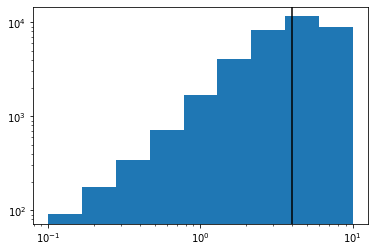

In [9]:
# fig=plt.figure()
# ax = fig.
plt.hist(maxminpT,bins=np.logspace(-1,1,10),log=True)
plt.axvline(4,color='black')
plt.semilogx()
plt.show()

In [10]:
out_data = np.zeros((numpass,50,4))

HT_muon = []
HT_tot = []

for n, index in enumerate(pass_indices):
    if n % 1000 == 0:
        print("Now processing event", n, "of", numpass)
    
    event = np.array(events[index])
    pTs = event[:,2]
    eta = event[:,3]
    
    PIDs = event[:,1]
    neutrinos = [12,14,16]
    
    ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
    isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)
        
    mu = np.argmax(pTs*ismuon)
    antimu = np.argmax(pTs*isantimuon)
    
    rejected = np.zeros(len(event), dtype=bool)
    rejected[mu] = True
    rejected[antimu] = True
    
    HT_tot += [np.sum(event[:,2])]
    
    pTs_muon = event[rejected,2]
    HT_muon += [np.sum(pTs_muon)]
    
    for neutPID in neutrinos:
        rejected += (np.abs(PIDs) == neutPID)
    
    event = event[np.logical_not(rejected)]
    
    
    pTs = event[:,2]
    etas = event[:,3]
    phis = event[:,4]
    Es = event[:,5]
    
    pxs = pTs*np.cos(phis)
    pys = pTs*np.sin(phis)
    pzs = pTs*np.sinh(etas)
    
    numparts = len(pTs)
    
    particles = []
    for i in range(numparts):
        particles += [fj.PseudoJet(pxs[i],pys[i],pzs[i],Es[i])]
    sequence = fj.ClusterSequence(particles,jet_def)
    reclustered = fj.sorted_by_pt(sequence.exclusive_jets(min(50,numparts)))
    
    
    numparts = min(50,len(reclustered))
    for j in range(numparts):
        particle = reclustered[j]
        out_data[n,j,0] = particle.pt()
        out_data[n,j,1] = particle.eta()
        out_data[n,j,2] = particle.phi() - np.pi
        out_data[n,j,3] = particle.E()
        
#     for j in range(numparts,50):
#         out_data[i,j,1] = jet.Eta
#         out_data[i,j,2] = jet.Phi

Now processing event 0 of 19864
Now processing event 1000 of 19864
Now processing event 2000 of 19864
Now processing event 3000 of 19864
Now processing event 4000 of 19864
Now processing event 5000 of 19864
Now processing event 6000 of 19864
Now processing event 7000 of 19864
Now processing event 8000 of 19864
Now processing event 9000 of 19864
Now processing event 10000 of 19864
Now processing event 11000 of 19864
Now processing event 12000 of 19864
Now processing event 13000 of 19864
Now processing event 14000 of 19864
Now processing event 15000 of 19864
Now processing event 16000 of 19864
Now processing event 17000 of 19864
Now processing event 18000 of 19864
Now processing event 19000 of 19864


In [10]:
np.logspace(-5,1,100)[33:-24]

array([0.001     , 0.00114976, 0.00132194, 0.00151991, 0.00174753,
       0.00200923, 0.00231013, 0.00265609, 0.00305386, 0.00351119,
       0.00403702, 0.00464159, 0.0053367 , 0.00613591, 0.0070548 ,
       0.00811131, 0.00932603, 0.01072267, 0.01232847, 0.01417474,
       0.01629751, 0.01873817, 0.02154435, 0.02477076, 0.02848036,
       0.03274549, 0.03764936, 0.04328761, 0.04977024, 0.05722368,
       0.06579332, 0.07564633, 0.0869749 , 0.1       , 0.1149757 ,
       0.13219411, 0.15199111, 0.17475284, 0.2009233 , 0.23101297,
       0.26560878, 0.30538555, 0.35111917])

In [ ]:
np.logspace(-5,1,75)[:-6]

In [11]:
out_data = out_data.reshape((-1,50*4))

In [12]:
columns = []
for i in range(50):
    columns += ['pT' + str(i), 'eta' + str(i), 'phi' + str(i), 'E' + str(i)]

In [14]:
outstore = pd.HDFStore("/home/jack/projects/EMD_VAE/compression_project/data/hv_signal.h5")
dictionary = dict(zip(columns, out_data.T))
out_df = pd.DataFrame(dictionary,columns=columns)
outstore.append('particles',out_df)
outstore.close()

In [64]:
len(rejected)

285

In [61]:
event[]

array([[ 0.00000e+00,  2.11000e+02,  1.09504e+00,  9.46629e-01,
         2.96872e+00,  1.62942e+00],
       [ 0.00000e+00, -2.11000e+02,  3.76502e-01,  1.90269e+00,
         3.01310e+00,  1.29763e+00],
       [ 0.00000e+00,  2.11000e+02,  5.92605e-01, -5.32236e+00,
        -2.65813e+00,  6.07040e+01],
       ...,
       [ 0.00000e+00, -1.30000e+01,  2.75282e+00, -6.18138e-01,
        -1.55738e-01,  3.29740e+00],
       [ 0.00000e+00,  1.30000e+01,  6.14126e+00, -6.91735e-01,
        -1.64541e-01,  7.67081e+00],
       [ 0.00000e+00, -1.30000e+01,  4.83169e+00, -7.26780e-01,
        -1.35814e-01,  6.16583e+00]])

In [3]:
data = reread = pd.read_hdf("/home/jack/projects/EMD_VAE/compression_project/data/hv_signal.h5")  

In [4]:
data

,pT0,eta0,phi0,E0,pT1,eta1,phi1,E1,pT2,eta2,...,phi47,E47,pT48,eta48,phi48,E48,pT49,eta49,phi49,E49
0,70.704955,-0.869069,-0.962585,99.178,60.757831,0.128332,2.286567,61.399,37.523946,-0.742735,...,0.908594,699.733,2.408873,5.683472,1.358679,354.112,2.001770,-6.011628,3.138658,408.018
1,487.546683,-0.037169,-1.823327,488.024,325.926558,-0.049529,-1.836855,327.231,216.687690,-0.328927,...,0.032787,327.018,3.533378,4.581975,2.931399,172.925,3.478957,2.852212,-2.114696,30.278
2,23.081995,-0.290822,2.330707,24.252,22.423606,-0.684999,-1.286990,27.997,21.411092,-0.310909,...,-0.672050,27.415,1.828158,6.670395,0.740582,720.830,1.519993,6.567201,2.217250,539.897
3,118.353176,-0.586996,1.965632,139.823,42.404567,0.891818,-0.748608,60.564,37.184144,-0.093812,...,-1.051685,5.491,1.089046,-6.486614,-0.747084,357.481,1.063945,1.617531,-1.575963,2.850
4,143.017841,0.343270,-1.283075,151.590,121.853259,-1.219391,-2.806089,224.472,109.835211,0.882134,...,0.828274,141.484,1.733333,6.562369,1.108940,613.429,1.660208,-5.593319,-2.946978,223.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19859,46.739646,1.640397,-0.913059,125.156,33.335578,2.292154,1.861910,166.692,14.774918,1.219381,...,-2.565230,1443.109,3.306707,-5.343641,1.047407,346.170,3.207515,6.236682,-2.588155,819.068
19860,42.003486,-0.497199,0.237550,48.282,33.589819,-0.632212,2.943531,40.859,23.597309,-1.207729,...,-1.774415,3.556,2.734375,-2.188131,1.668719,12.425,2.435110,0.176923,1.048544,2.684
19861,38.152677,2.452715,-1.073276,223.490,34.590582,1.320353,1.973850,69.650,18.195497,1.535395,...,-1.055960,516.409,2.188813,6.919973,1.901359,1113.123,1.988145,-1.273464,3.129310,4.132
19862,71.413591,1.428271,1.729076,157.593,65.055543,-2.205098,-1.559544,298.806,22.463997,1.621055,...,-1.095347,3.603,2.333619,2.960073,-1.483006,22.607,2.320120,-5.554354,-2.353314,299.659
